In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sc
import h5py

from sklearn.datasets import make_circles

In [2]:
class layer_nn():
  def __init__(self,act_fun,nlayer_present, nlayer_before):
    """
    act_fun: función de activación para la red neuronal
    nlayer_present: # de redes neuronales en la capaque hay  presente
    nlayer_before: # de redes neuronales que hay que la capa anterior
    """
    self.act_fun=act_fun

    self.theta = np.random.randn(nlayer_present, nlayer_before) * np.sqrt(1 / nlayer_before)
    self.b = np.zeros((nlayer_present, 1))
    """
    al final estas parametros recomendados por la IA, fueron más eficientes que los
    parametros al final
    """


   # self.b=2*np.random.random((nlayer_present,1))-1

    #self.theta=2*np.random.random((nlayer_present,nlayer_before))-1

    #self.theta=np.random.randn(nlayer_present,nlayer_before) * np.sqrt(2 / nlayer_before)

In [3]:
#Funciones de activación
f = (lambda x: 1/(1+np.exp(-x)),
     lambda x: 1/(1+np.exp(-x))*(1-(1/(1+np.exp(-x)))))

g = (lambda x: np.tanh(x),
     lambda x: 1-np.tanh(x)**2)

r= (lambda x: np.maximum(0,x),
    lambda x: np.where(x>0,1,0))


In [4]:
n=12288
#topology=[n,4,2,1]
#topology=[n,8,4,16,8,1]
topology=[n,256,128,64,32,1]
#activation=[None,r,r,f]
activation=[None,r,r,r,r,f]

"""
despues de ensayar con varias topologias y activaciones esta es la que dio mejores resultados
"""


In [5]:
#Creación de las capas con sus respectivas redes neuronales
nn=[]
for l,val in enumerate(topology[:-1]):
  # Para cada capa, crea una capa con la función de activación correspondiente

  nn.append(layer_nn(activation[l+1],topology[l+1],topology[l]))

In [6]:
def forward_pass(A0,nn):
  """A0 es la matriz de características de entrada por cada elememento"""

  z_l=[None] #Contiene suma ponderada por cada capa
  A_l=[A0] #Contiene matrices que representa el valor de la función de activación por cada capa(que serían los parametro de la capa sigiuiente)


  for i in range(len(nn)):

    z = nn[i].theta @ A0 + nn[i].b

    a = nn[i].act_fun[0](z)


    z_l.append(z)
    A_l.append(a)

    A0 = a


  return z_l, A_l


In [31]:
epsilon = 1e-10
coste = (lambda Yh, Yr: -1*np.mean(Yr*np.log(Yh + epsilon) + (1 - Yr)*np.log(1 - Yh + epsilon)),
         lambda Yh, Yr: Yr/(Yh + epsilon) - (1 - Yr)/(1 - Yh + epsilon))

"""
se le agrega un epsilon para evitar error de division por cero
"""

'\nse le agrega un epsilon para evitar error de division por cero\n'

In [8]:
def Backward_Pass(forward_pass_values, neural_net, X, Y, cost_fun, lr):
    """
    Realiza el Backward Pass y actualiza los pesos y sesgos.

    """
    z = forward_pass_values[0][1:]  # Excluir el primer None
    a = forward_pass_values[1]
    number_layers = len(neural_net)
    delta = []

    # Calcular delta para la última capa
    delta.insert(0, (a[-1] - Y) * neural_net[-1].act_fun[1](z[-1]))

    # Recorrer las capas intermedias y calcular delta

    for i in range(number_layers - 2, -1, -1):
        _theta = neural_net[i + 1].theta

        delta.insert(0, (_theta.T @ delta[0]) * neural_net[i].act_fun[1](z[i]))
       # _theta = neural_net[i + 1].theta.T

    # Actualización de parámetros
    for i in range(number_layers - 1, -1, -1):
        neural_net[i].b -= lr * np.mean(delta[i], axis=1, keepdims=True)

        if i == 0:  # Primera capa
            neural_net[i].theta -= lr * delta[i] @ a[0].T
        else:  # Para las demás capas
            neural_net[i].theta -= lr * delta[i] @ a[i].T

             # Obtener a[-1] del forward pass actualizado

    return neural_net


In [9]:
data_train = "/content/train_catvnoncat.h5"  # Replace with the actual path
train_dataset = h5py.File(data_train, "r")
data_test= "/content/test_catvnoncat.h5"
test_dataset = h5py.File(data_test, "r")

In [10]:
# Read the data
xtrain_classes, xtrain, train_label =\
train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest,test_label =\
test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]

In [11]:
# Check if train_label is already a NumPy array
if not isinstance(train_label, np.ndarray):
    train_labels_np = train_label[:]  # Convert to NumPy array if needed
else:
    train_labels_np = train_label  # Use directly if it's already a NumPy array

In [12]:
xtrain_= np.reshape(xtrain,(209, 64*64*3))/255
xtest_ = np.reshape(xtest,(50, 64*64*3))/255

Epoch 1/1000, Cost: 0.7063589811466553
Epoch 101/1000, Cost: 0.5868083158725864
Epoch 201/1000, Cost: 0.4558908368168191
Epoch 301/1000, Cost: 0.29738930454059037
Epoch 401/1000, Cost: 0.055127912985598784
Epoch 501/1000, Cost: 0.023925907727025422
Epoch 601/1000, Cost: 0.016237052898269492
Epoch 701/1000, Cost: 0.01265932892983176
Epoch 801/1000, Cost: 0.01053153819965361
Epoch 901/1000, Cost: 0.009116771311017452
Epoch 1000/1000, Cost: 0.00811266771314922


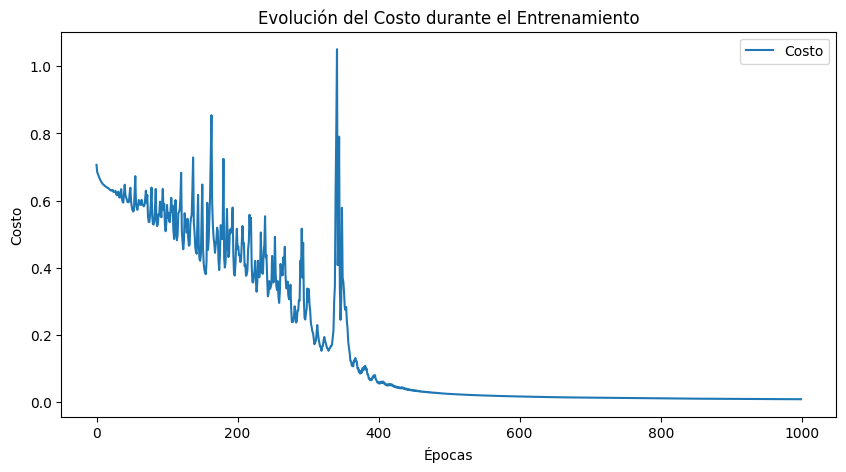

In [13]:

# Número de iteraciones (epochs) y tasa de aprendizaje
epochs = 1000
learning_rate = 0.001
cost_history = []

for epoch in range(epochs):
    # Forward Pass
    forward_values = forward_pass(xtrain_.T, nn)
    Y_hat = forward_values[1][-1]  # a[-1] contiene las predicciones

    # Calcular el costo
    cost = coste[0](Y_hat, train_labels_np)
    cost_history.append(cost)

    # Backward Pass
    nn = Backward_Pass(forward_values, nn, xtrain_, train_label, coste, learning_rate)

    # Mostrar progreso cada 100 iteraciones
    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, Cost: {cost}")

# Graficar la evolución del costo
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), cost_history, label="Costo")
plt.xlabel("Épocas")
plt.ylabel("Costo")
plt.title("Evolución del Costo durante el Entrenamiento")
plt.legend()
plt.show()


In [14]:
forward_values_test = forward_pass(xtest_.T, nn)
Y_hat_test = forward_values_test[1][-1]  # Obtengo predicciones para el conjunto de testeo

In [15]:
"""
Y_hat_test contiene las salidas de la función activación de la ultima capa, que representa
la probabilidad de que la imagen sea una imagen de gato.

"""
predictions = (Y_hat_test > 0.5).astype(int)  # Convertir la probabilidades en 1 o 0

In [29]:
accuracy = np.mean(predictions == test_label)
print(f"Exactitud en el conjunto de test: {accuracy}")

Exactitud en el conjunto de test: 0.7


In [27]:
from sklearn.metrics import f1_score

f1 = f1_score(test_label, predictions[0])
print(f"F1 score: {f1}")

F1 score: 0.7619047619047619
